In [1]:
import cartopy
import cartopy.mpl.geoaxes
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import seaborn as sns
import seawater as sw
from xmitgcm import open_mdsdataset

In [2]:
def gaussian_windstress(nt=120, end_time=60, max_tau=0.1, sigma=1, center=3.5, angle_up=120.):
    '''nt=120  number of wind records
       end_time = 60  end time of records
       max_tau = 0.1  original 0.1
       sigma = 1 
       center = 3.5  base 3.5 hr, faster 2.5 hr, slower 4.5
       angle_up = 120. Rotation angle (in deg) to get alongshore winds'''
    
    t = np.linspace(0,end_time,nt)  #time array of wind records
    gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
    mask = t>center
    gauss[mask]=0
    windstress= gauss.copy()
    return(windstress, t)

In [3]:
## --- Input Files ----
# Base run (Feb TS) (Substitute with your PATH)
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'
iters = [10]
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels, iters=iters)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels, iters=iters)

# Aug TS run (Substitute with your PATH)
outdirS = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/04_SVB_augTS_output/'
outdirS2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/04_noSVB_augTS/'

dsS = open_mdsdataset(outdirS, prefix=['eta','dynVars'], levels=levels, iters=iters)
dsS2 = open_mdsdataset(outdirS2, prefix=['eta','dynVars'], levels=levels, iters=iters)

In [4]:
# --- Get coastline points ---
df = pd.read_csv('coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [5]:
# --- Bathy and masks ---
nt = 720
time = np.arange(0,nt)*600

depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360
Z = ds2['Z'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)

# bay centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

<ipython-input-6-e3a9c800135c>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon,lat,dep_maskedSVB,
<ipython-input-6-e3a9c800135c>:17: UserWarning: No contour levels were found within the data range.
  ax.contour(lon,lat,depth[:,:], levels=[0], colors='brown', linestyles=':', linewidths=2)
<ipython-input-6-e3a9c800135c>:18: UserWarning: No contour levels were found within the data range.
  ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')
<ipython-input-6-e3a9c800135c>:97: RuntimeWarning: invalid value encountered in sqrt
  ax4.plot(100*np.sqrt(N2_feb),-pave_feb,'-', color=color, label='febTS', alpha=0.6, linewidth=2)
<ipython-input-6-e3a9c800135c>:98: RuntimeWarning: invalid value encounte

Text(-0.15, 1, '(b)')

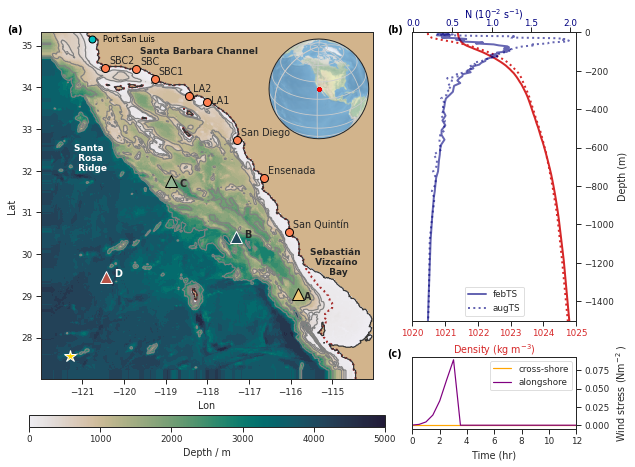

In [6]:
## ==== FIGURE =====
sns.set_style('ticks')
sns.set_context('paper')
fig = plt.figure(figsize=(7.6,5.0))
ax = fig.add_axes([-0.1, -0.15, 0.65, 1.25])
ax.set_facecolor('tan')

# --- Plot bathymetry ---
pc = ax.pcolormesh(lon,lat,dep_maskedSVB,
                  vmin=0, vmax=5000, cmap=cmo.cm.rain)
cb = plt.colorbar(pc, ax=ax, label='Depth / m',pad=0.08,
                  aspect=30, orientation='horizontal')

cn = ax.contour(lon,lat,dep_maskedSVB, colors=['0.5'], 
                levels=[250,500,1000,2000,3000])

ax.contour(lon,lat,depth[:,:], levels=[0], colors='brown', linestyles=':', linewidths=2)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_aspect(1)

# --- Plot key geographical points ---
for kk, lab in zip([47,150,230,307,335,400,440,450], 
                   ['San Quintín' ,'Ensenada','San Diego','LA1','LA2','SBC1','SBC','SBC2']):
    ii = int(lon_ii[kk])
    jj = int(lat_jj[kk])
    
    ax.plot(LON[0,ii],LAT[jj,0],'o', 
            markersize=8, color='coral', markeredgecolor='k')
    if lab == 'LA1':
        ax.text(LON[0,ii]+0.1,LAT[jj,0]-0.05, lab)
    else:
        ax.text(LON[0,ii]+0.1,LAT[jj,0]+0.1, lab)
       
ax.text(0.89,0.3,'Sebastián \n Vizcaíno \n Bay',fontsize=9, fontweight='demibold',horizontalalignment='center',
        transform=ax.transAxes)
ax.text(0.3,0.94,'Santa Barbara Channel',fontsize=9, transform=ax.transAxes,
        fontweight='demibold')
ax.text(0.15,0.6,'Santa \n Rosa \n Ridge',color='w',fontsize=9, transform=ax.transAxes,
        fontweight='bold', horizontalalignment='center')

ax.plot(-120.756, 35.1719,  'co', markeredgecolor='k', markersize=7)
ax.text(-120.5, 35.1, 'Port San Luis', color='k',fontsize=8)

#---- Plot globe -------------------------
axins = inset_axes(ax, width="30%", height="30%", loc= 'upper right',
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Orthographic(central_latitude=32, 
                                                                            central_longitude=-118)))
axins.add_feature(cartopy.feature.OCEAN, zorder=0)
axins.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axins.gridlines()
axins.stock_img()
axins.plot(lon, np.ones_like(lon)*27,'r.',transform=cartopy.crs.Orthographic(-118, 32))
axins.plot(lon, np.ones_like(lon)*35.3,'r.',transform=cartopy.crs.Orthographic(-118, 32))

# ------------- wind stress ---------------------------
ax2 = fig.add_axes([0.6, 0., 0.3, 0.2])
tau_along, t = gaussian_windstress()
ax2.plot(t,np.zeros_like(t), color='orange', label='cross-shore')
ax2.plot(t,tau_along, color='purple', label='alongshore')
ax2.set_xlabel('Time (hr)')
ax2.set_ylabel(r'Wind stress (Nm$^{-2}$ )')
ax2.yaxis.set_label_position("right")
ax2.set_xlim([0,12])
ax2.yaxis.tick_right()
ax2.legend()

# ------------- N and rho ---------------------------
alpha=2.E-4,
beta=7.4E-4,
rhoNil=999.8

pden_feb = rhoNil*(np.ones(np.shape(ds.SALT[0,:,100,100].data)) - alpha*(ds.THETA[0,:,100,100].data) + beta*(ds.SALT[0,:,100,100].data))
N2_feb,q,pave_feb  = sw.bfrq(ds.SALT[0,:,100,100].data,ds.THETA[0,:,100,100].data,-ds.Z.data)

pden_aug = rhoNil*(np.ones(np.shape(dsS.SALT[0,:,100,100].data)) - alpha*(dsS.THETA[0,:,100,100].data) + beta*(dsS.SALT[0,:,100,100].data))
N2_aug,q,pave_aug  = sw.bfrq(dsS.SALT[0,:,100,100].data,dsS.THETA[0,:,100,100].data,-dsS.Z.data)

ax3 = fig.add_axes([0.6, 0.3, 0.3, 0.8])
color = 'tab:red'
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(r'Density (kg m$^{-3}$)',color=color)
ax3.plot(pden_feb,ds.Z.data,'-', color=color, label='winTS', alpha=1, linewidth=2)
ax3.plot(pden_aug,dsS.Z.data,':', color=color, label='sumTS', alpha=1, linewidth=2)

ax3.tick_params(axis='x', labelcolor=color)
ax3.set_ylim(-3000,0)
ax3.set_xlim(1020, 1025)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax4 = ax3.twiny() 
color = 'navy'
ax4.set_xlabel(r'N (10$^{-2}$ s$^{-1}$)', color=color, labelpad=0.5)
ax4.plot(100*np.sqrt(N2_feb),-pave_feb,'-', color=color, label='febTS', alpha=0.6, linewidth=2)
ax4.plot(100*np.sqrt(N2_aug),-pave_aug,':', color=color, label='augTS', alpha=0.6, linewidth=2)
ax4.tick_params(axis='x', labelcolor=color, pad=0)
ax4.set_ylim(-1500,0)
ax4.legend(loc=8)

#--- Plot location of Initial T and S profiles ----
ax.plot(LON[0,45],LAT[40,0], '*', color='gold', markersize=12, markeredgecolor='w')


#--- Plot w stations -----
pta = [100,180]
ptb = [395,150]
ptc = [200,350]
ptd = [300,250]
colors = [ "#b75347", "#edc775", "#94b594", "#224b5e"]
ax.plot(lon[pta[0]], lat[pta[1]], '^', color=colors[0],
         markeredgecolor='1', markersize=12)
ax.plot(lon[ptb[0]], lat[ptb[1]], '^', color=colors[1],
         markeredgecolor='0', markersize=12)
ax.plot(lon[ptc[0]], lat[ptc[1]], '^', color=colors[2],
         markeredgecolor='0', markersize=12)
ax.plot(lon[ptd[0]], lat[ptd[1]], '^', color=colors[3],
         markeredgecolor='1', markersize=12)

ax.text(lon[pta[0]]+0.2, lat[pta[1]], 'D', fontweight='bold', color='w')
ax.text(lon[ptb[0]]+0.15, lat[ptb[1]]-0.15, 'A', fontweight='bold')
ax.text(lon[ptc[0]]+0.2, lat[ptc[1]]-0.15, 'C', fontweight='bold')
ax.text(lon[ptd[0]]+0.2, lat[ptd[1]], 'B', fontweight='bold')

# --- Add labels to each panel ---
ax.text(-0.1, 1, '(a)', fontweight='bold', color='k', 
        transform=ax.transAxes)
ax2.text(-0.15,1, '(c)', fontweight='bold', 
         color='k',transform=ax2.transAxes)
ax3.text(-0.15,1, '(b)', fontweight='bold', 
         color='k',transform=ax3.transAxes)

# --- save figure -----
plt.savefig('figure1.png', dpi=500, bbox_inches='tight')